### U-Net Implementation of Knee Bony Image Segmentation
### Data Science Capstone 2020
#### Matthew Vue and Maryam Vazirabad

##### Importing necessary libraries, specifically using Keras to build model:

In [115]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.preprocessing import normalize

##### Setting size of images:

In [2]:
# Set some parameters
im_width = 256
im_height = 256
border = 5

##### Checking how many images we have:

In [3]:
ids = next(os.walk(r'C:\Users\vazir\Desktop/kneeData/kneeData/frames'))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  300


###### Changing images to given shape and type, with zeros.

In [4]:
X = np.zeros((len(ids), im_height, im_width, 3), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 3), dtype=np.float32)

###### Loading images and corresponding masks:

In [5]:
# getting all the x-rays and labels

# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img(r'C:\Users\vazir\Desktop/kneeData/kneeData/frames/'+id_, color_mode="rgb")
    x_img = img_to_array(img)
    x_img = resize(x_img, (256, 256, 3), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img(r'C:\Users\vazir\Desktop/kneeData/kneeData/masks/'+id_, color_mode="rgb")) 
    
    mask = resize(mask, (256,256,3), preserve_range = True)
    # Save images
   
    X[n] = x_img/255.0
    y[n] = mask/255.0

<ipython-input-5-065ada7d4805>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):


###### Creating a new mask set with the dimension (# of training images, height, width, #of classes to segment):

In [7]:
# creating a new mask set with the dimension (# of training images, height, width, #of classes to segment)

Femur = [0,0,1]
Fibula = [1,0,0]
Patella = [0,1,0]
Tibia = [1,1,0]

count1 = 0
count2 = 0
count3 = 0
count4 = 0
count5 = 0
newY = np.zeros((len(ids), im_height, im_width, 5), dtype=np.float32)

# classifying each pixel
for l in tqdm_notebook(range(len(y))):
    for i in range(y[l].shape[0]):
        for x in range(y[l].shape[1]):
            if np.array_equal(y[l][i][x], Femur):
                newY[l][i][x] = [1,0,0,0,0]
            elif np.array_equal(y[l][i][x], Fibula):
                newY[l][i][x] = [0,1,0,0,0]
            elif np.array_equal(y[l][i][x], Patella):
                newY[l][i][x] = [0,0,1,0,0]
            elif np.array_equal(y[l][i][x], Tibia): 
                newY[l][i][x] = [0,0,0,1,0]
            else:
                newY[l][i][x] = [0,0,0,0,1]

<ipython-input-7-7fb322e07d90>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for l in tqdm_notebook(range(len(y))):


###### Checking the count of pixels per class for an X-ray image:

In [8]:
# just checking the count of pixels per class
count1 = 0
count2 = 0
count3 = 0
count4 = 0
count5 = 0

for l in tqdm_notebook(range(1)):
    for i in range(newY[l].shape[0]):
        for x in range(newY[l].shape[1]):
            if np.array_equal(newY[l][i][x],[1,0,0,0,0]):
                count1 = count1 + 1
            elif np.array_equal(newY[l][i][x], [0,1,0,0,0]):
                count2 = count2 + 1
            elif np.array_equal(newY[l][i][x], [0,0,1,0,0]):
                count3 = count3 + 1
            elif np.array_equal(newY[l][i][x], [0,0,0,1,0]):
                count4 = count4 + 1    
            else:
                count5 = count5 + 1

<ipython-input-8-7c894c2a3ed4>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for l in tqdm_notebook(range(1)):


###### Setting our mask set to the new mask set with dimension 
###### (# of training images, height, width, #of classes to segment):

In [10]:
# setting our mask set equal to "newY"
y=newY

###### Creating train and test sets:

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [12]:
y_train[0].shape

(256, 256, 5)

###### Definition of convolution layer:

In [13]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

###### Definition of U-net model:

In [14]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    # notice the number "5" in our output which is the number of classes we have
    outputs = Conv2D(5, (1, 1), activation='softmax')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [15]:
input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

In [16]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 256, 256, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 256, 256, 16) 0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [17]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-X-Rays.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

###### Running the model:

In [18]:
results = model.fit(X_train, y_train, batch_size=32, epochs=43, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Train on 270 samples, validate on 30 samples
Epoch 1/50
270/270 [==============================] - 128s 474ms/step - loss: 1.6140 - accuracy: 0.3588 - val_loss: 1.6177 - val_accuracy: 0.4180

Epoch 00001: val_loss improved from inf to 1.61765, saving model to model-X-Rays.h5
Epoch 2/50
270/270 [==============================] - 122s 453ms/step - loss: 1.3106 - accuracy: 0.7002 - val_loss: 1.5244 - val_accuracy: 0.6579

Epoch 00002: val_loss improved from 1.61765 to 1.52439, saving model to model-X-Rays.h5
Epoch 3/50
270/270 [==============================] - 124s 460ms/step - loss: 1.1930 - accuracy: 0.7555 - val_loss: 1.3968 - val_accuracy: 0.7346

Epoch 00003: val_loss improved from 1.52439 to 1.39680, saving model to model-X-Rays.h5
Epoch 4/50
270/270 [==============================] - 122s 453ms/step - loss: 1.1244 - accuracy: 0.7673 - val_loss: 1.2498 - val_accuracy: 0.7544

Epoch 00004: val_loss improved from 1.39680 to 1.24984, saving model to model-X-Rays.h5
Epoch 5/50
270/270 

In [19]:
model.load_weights('model-X-Rays.h5')

###### We are using the model to segment the X-rays in the test set.

In [20]:
out = model.predict(X_valid)

In [21]:
model.evaluate(X_valid, y_valid)

30/30 [==============================] - 4s 119ms/step


[0.16360418498516083, 0.9560277462005615]

###### Below is a graph of Accuracy Vs. # of Epochs. As the number of epochs increase,  the accuracy also increases.

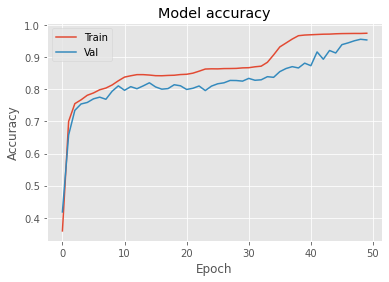

In [22]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

###### Below is a graph of Loss Vs. # of Epochs. As the number of epochs increases, the loss of the model decreases.

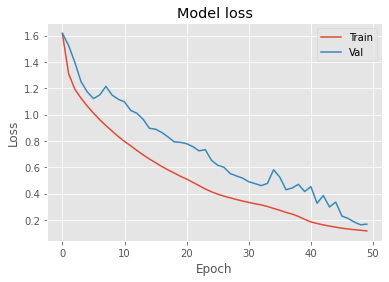

In [23]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

###### The method below is used to read labels and pixel values from a text file.

In [39]:
def parse_code(dataPath):
    '''Function to parse lines in a text file, returns separated elements (label codes and names in this case)
    '''
    colors = []
    labels = []
    for line in open(dataPath+"label_colors.txt"):
        if len(line.strip().split("\t")) == 2:
            a = line.strip().split("\t")
            color = tuple(int(i) for i in a[0].strip().split(' '))
            colors = colors + [color]
            label = a[1]
            labels = labels + [label]

    return colors, labels

In [40]:
label_codes, label_names = parse_code(r'C:\Users\vazir\Desktop/kneeData/kneeData/')
label_codes, label_names = list(label_codes), list(label_names)
label_codes, label_names

([(0, 0, 255), (255, 0, 0), (0, 255, 0), (255, 255, 0), (0, 0, 0)],
 ['Femur', 'Fibula', 'Patella', 'Tibia', 'Background'])

In [41]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}
id2code

{0: (0, 0, 255),
 1: (255, 0, 0),
 2: (0, 255, 0),
 3: (255, 255, 0),
 4: (0, 0, 0)}

###### Getting the mask predicted by the model

In [112]:
# getting the image predicted by the model by converting to corresponsing pixel values
convert = np.zeros((im_height, im_width, 3), dtype=np.float32)
pred = out[3]

for i in range(pred.shape[0]):
    for x in range(pred.shape[1]):
        pixel = list(pred[i][x])
        maxP = pixel.index(max(pixel))
        code = id2code[maxP]
        converted = np.array(code)
        convert[i][x] = converted

###### The output below shows an X-ray image and the corresponding mask predicted by the model.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


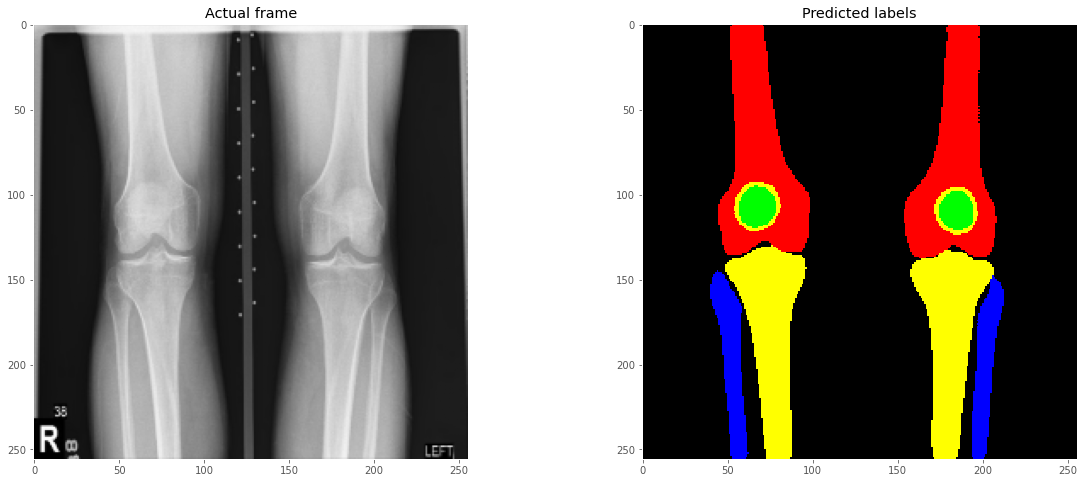

In [114]:
from matplotlib import pyplot as plt
img = convert


fig = plt.figure(figsize=(20,8))
    
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(X_valid[3])
ax1.title.set_text('Actual frame')
ax1.grid(b=None)
    
    
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Predicted labels')
ax2.imshow(img, interpolation='nearest')
ax2.grid(b=None)
    